<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1aS4vX-ucDKBmZmZMrBwgjl_DvLAadX2C" width=900/></p>


<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h1 style="text-align: center;"><b>Семинар. Логистическая регрессия</b></h1>

В этом семинаре мы создадим свой класс логистической регрессии, который обучим с помощью градиентного спуска.

Логистическая регрессия --- это линейный алгоритм классификации на два класса $\{0, 1\}$, основанный на подборе весов модели для оптимизации логистической функции потерь.

**Предсказания.** С помощью функции сигмоиды:
$$\sigma(t) = \frac{1}{1 + e^{-t}}$$ можно вычислять вероятность принадлежности объекта классу $+1$ против класса $0$ по формуле $$y_{pred} = \sigma(\langle \mathbf{x}, \mathbf{w} \rangle).$$

Значение $\langle \mathbf{x}, \mathbf{w} \rangle$, то есть выход модели до применения сигмоиды, часто называют **логитом**.


**Функция потерь.**  В качестве функции потерь выступает LogLoss (логистическая функция потерь). Для одного объекта:

$$
L(\mathbf{w}) = -y\, \log\,y_{pred} - (1-y)\,\log\,(1-y_{pred})
$$

Здесь

* $\mathbf{x} = (1, x_1, \ldots, x_n)$ --- вектор признаков объекта (нулевой признак отвечает за свободный член в скалярном произведении $\langle \mathbf{x}, \mathbf{w}\rangle$);
* $y \in \{0, 1\}$ --- метка (истинного) класса объекта;
* $y_{pred} = \sigma(\langle \mathbf{x}, \mathbf{w} \rangle)$ -- вероятность класса $1$, предсказанная моделью;
* $\mathbf{w} = (w_0, w_1, \ldots, w_n)$ --- вектор весов ($w_0$ играет роль свободного члена).


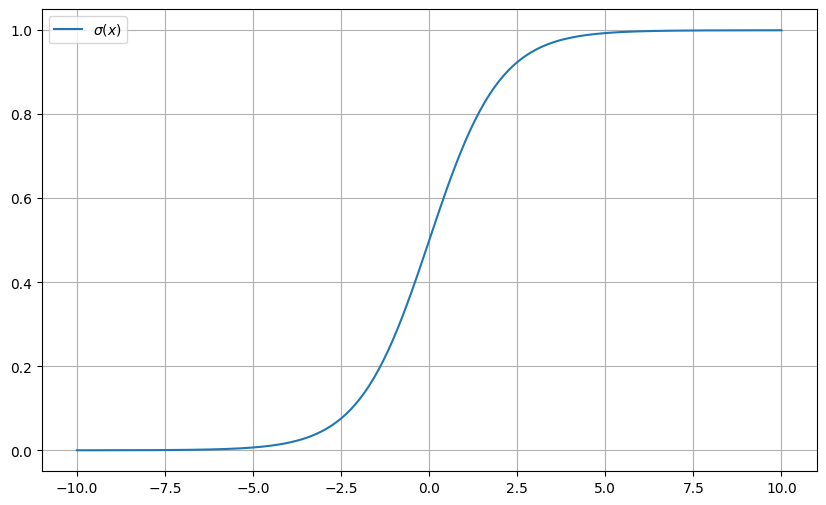

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

grid = np.linspace(-10, 10, 300)

plt.figure(figsize=(10,6))
plt.plot(grid, 1. / (1 + np.exp(-grid)), label='$\sigma(x)$')
plt.legend()
plt.grid(True)
plt.show()

Процесс подбора логистической регрессии состоит в градиентном спуске производится (стохастическим) градиентным спуском.

**Градиент функции потерь для одного объекта**:
$$
\frac{\partial{L}}{\partial{\mathbf{w}}}
= \left(-\frac{y}{y_{pred}} + \frac{1-y}{1-y_{pred}}\right)\frac{\partial{y_{pred}}}{\partial{\mathbf{w}}}
$$

$$
\frac{\partial{y_{pred}}}{\partial{\mathbf{w}}} = \frac{-1}{(1+e^{-\langle \mathbf{x}, \mathbf{w} \rangle})^2} e^{-\langle \mathbf{x}, \mathbf{w} \rangle} (-\mathbf{x}) = y_{pred}(1-y_{pred})\mathbf{x}
$$

$$
\frac{\partial{L}}{\partial{\mathbf{w}}} = (y_{pred} - y) \mathbf{x}
$$

**Шаг градиентного спуска для всей матрицы $X$**:

$$
\frac{\partial{L}}{\partial{\mathbf{w}}} = \frac{1}{\ell}((\mathbf{y}_{pred} - \mathbf{y})^TX)^T = \frac{1}{\ell}X^T(\mathbf{y}_{pred} - \mathbf{y}).
$$


**Шаг градиентного спуска**:
$$\mathbf{w} := \mathbf{w} - \alpha \frac{\partial{L}}{\partial{\mathbf{w}}}.$$



## Свой класс логистической регрессии
Реализуйте методы класса логистической регрессии. Произведите обучение градиентным спуском по всей выборке с фиксированным градиентным спуском.

In [2]:
class MyLogisticRegression(object):
    def __init__(self):
        self.coef_ = None
        self.intercept_ = None


    def sigmoid(self, t):
        return 1. / (1 + np.exp(-t))


    def grad(self, X, y_true, y_pred):
        l = X.shape[0]
        grad = X.T @ (y_pred - y_true) / l

        return grad


    def fit(self, X, y, max_iter=100, lr=0.1):
        # Принимает на вход X, y и вычисляет веса по данной выборке.
        # Множество допустимых классов: {0, 1}
        # Не забудьте про фиктивный признак, равный 1!
        X = np.array(X)
        y = np.array(y)
        assert len(y.shape) == 1 and len(X.shape) == 2
        assert X.shape[0] == y.shape[0]

        y = y[:, np.newaxis]
        l, n = X.shape
        # Добавляем признак из единиц
        X = np.hstack([np.ones([X.shape[0], 1]), X])  # [l, n+1]

        # Инициализируем веса
        weights = np.random.randn(n+1, 1)

        losses = []

        for iter_num in range(max_iter):
            # calculate grad
            logits = X @ weights  # [l, 1]
            y_pred = self.sigmoid(logits)  # [l, 1]
            grad = self.grad(X, y, y_pred)  # [n+1, 1]
            # update weights
            weights -= grad * lr

            # calculate loss
            loss = self.loss(y, y_pred)
            losses.append(loss)

        # assign coef, intersept
        self.coef_ = weights[1:]
        self.intercept_ = weights[0]

        return losses


    def predict_proba(self, X):
        # Принимает на вход X и возвращает ответы модели
        X = np.array(X)
        X = np.hstack([np.ones([X.shape[0], 1]), X])  # [l, n+1]
        weights = np.concatenate([self.intercept_.reshape(-1, 1), self.coef_], axis=0)  # [n+1, 1]
        logits = (X @ weights)  # [l, 1]

        return self.sigmoid(logits)


    def predict(self, X, threshold=0.5):
        return self.predict_proba(X) >= threshold


    def loss(self, y, p):
        p = np.clip(p, 1e-10, 1 - 1e-10)
        return -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))

## Создание датасета

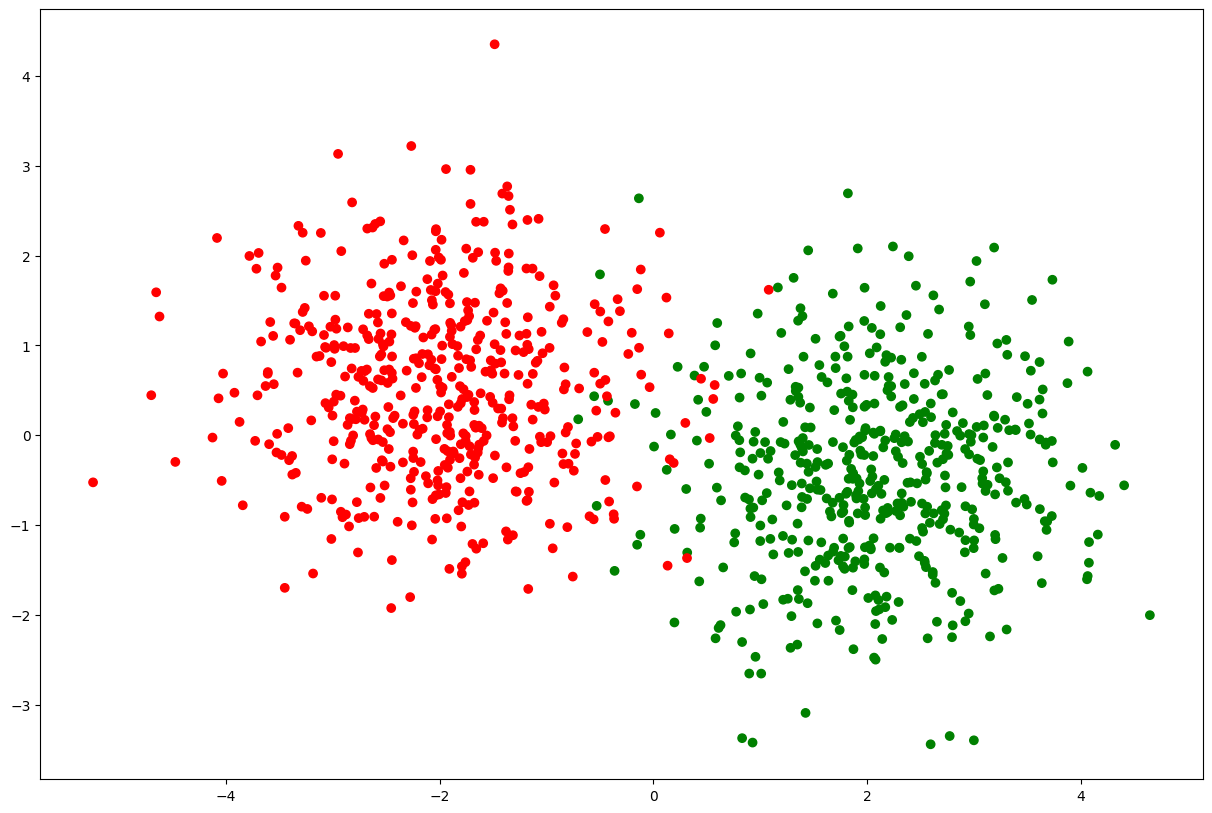

In [3]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, centers=[[-2,0.5],[2,-0.5]], cluster_std=1, random_state=42)

colors = ("red", "green")
colored_y = np.zeros(y.size, dtype=str)

for i, cl in enumerate([0,1]):
    colored_y[y == cl] = str(colors[i])

plt.figure(figsize=(15,10))
plt.scatter(X[:, 0], X[:, 1], c=colored_y)
plt.show()

In [4]:
clf = MyLogisticRegression()

losses = clf.fit(X, y, max_iter=1000)

coef, intercept = clf.coef_, clf.intercept_

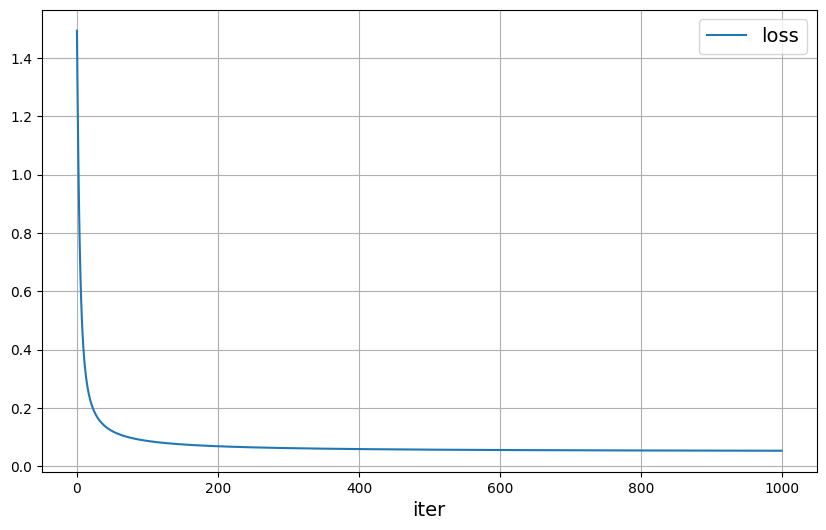

In [5]:
plt.figure(figsize=(10,6))
plt.plot(losses, label='loss')
plt.legend(fontsize=14)
plt.xlabel('iter', fontsize=14)
plt.grid()

In [6]:
coef, intercept

(array([[ 3.06273356],
        [-0.58849965]]),
 array([-0.0793848]))

## Визуализация результатов

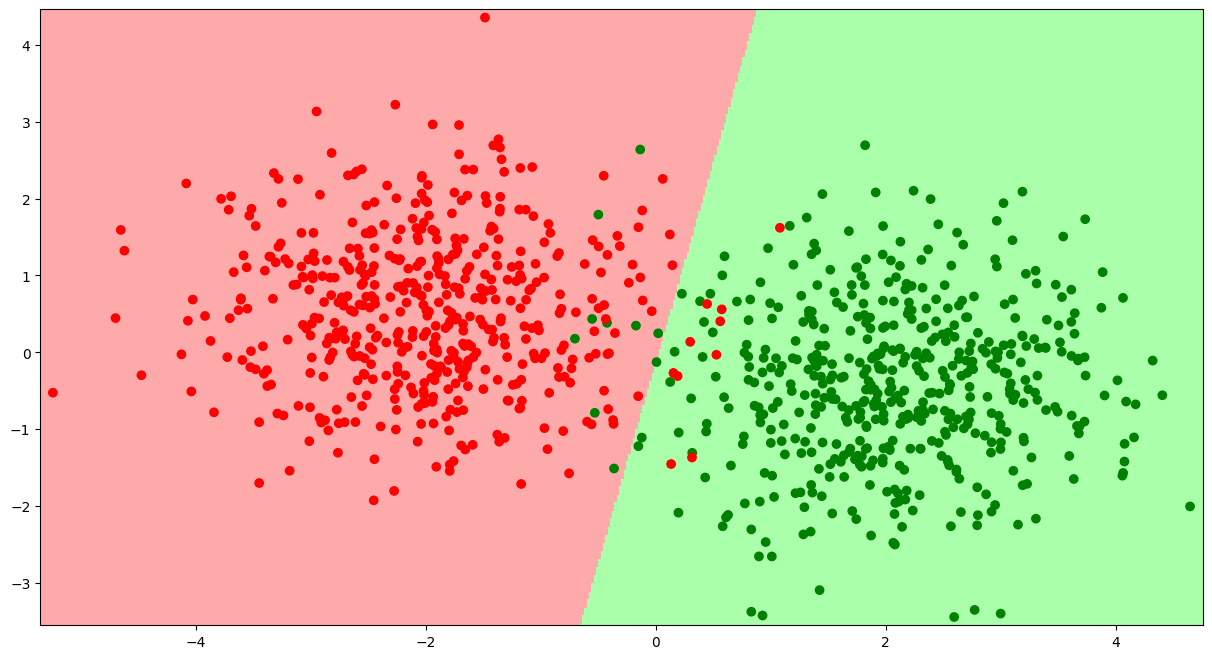

In [7]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

plt.figure(figsize=(15,8))

eps = 0.1
xx, yy = np.meshgrid(np.linspace(np.min(X[:,0]) - eps, np.max(X[:,0]) + eps, 500),
                     np.linspace(np.min(X[:,1]) - eps, np.max(X[:,1]) + eps, 500))


Z = clf.predict(np.stack([xx.ravel(), yy.ravel()]).T)

Z = Z.reshape(xx.shape)

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

plt.scatter(X[:, 0], X[:, 1], c=colored_y)
plt.show()

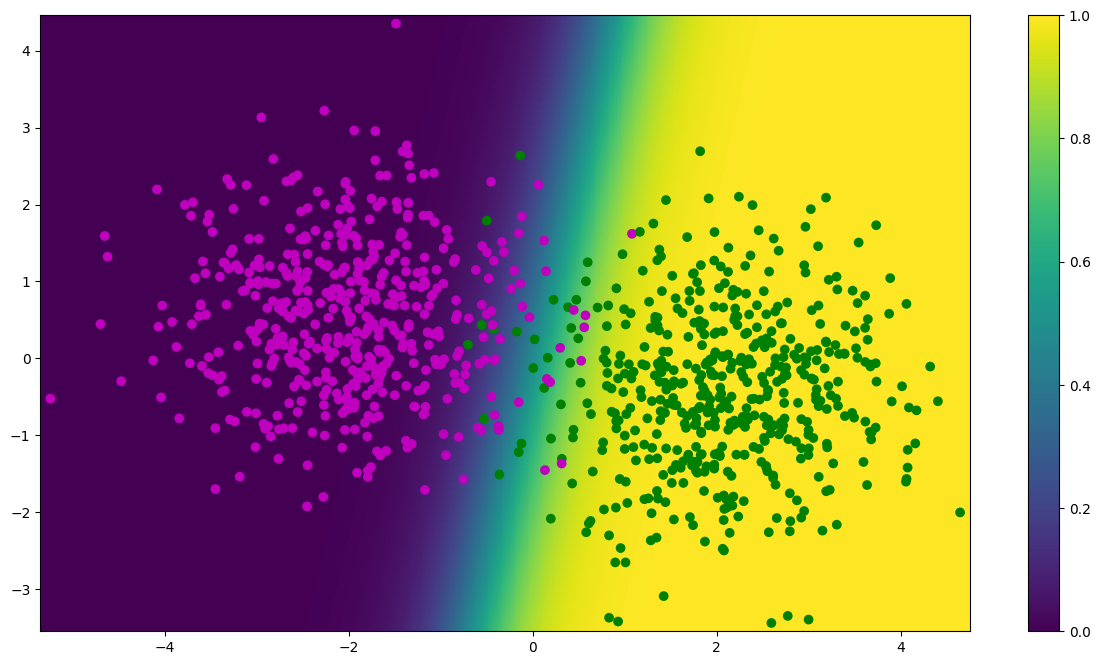

In [8]:
colors = ("magenta", "green")
colored_y = np.zeros(y.size, dtype=str)

for i, cl in enumerate([0,1]):
    colored_y[y == cl] = str(colors[i])


plt.figure(figsize=(15,8))

Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.get_cmap('viridis'))

plt.scatter(X[:, 0], X[:, 1], c=colored_y)
plt.colorbar()
plt.show()

In [9]:
from sklearn.metrics import accuracy_score

In [10]:
accuracy_score(y, clf.predict(X))

0.981